# Vertices for Hubbard atom

In [1]:
using Revise
using PyPlot

using OvercompleteIR
using OvercompleteIR.Atom
using OvercompleteIR.SparseIR
using OvercompleteIR.LinearAlgebra

using ITensors
using MSSTA

d = DensityChannel()
m = MagneticChannel()
s = SingletChannel()
t = TripletChannel()

TripletChannel()

In [2]:
U = 0.1
β = 0.2
at = Atom.HubbardAtom(U, β)
conv = Atom.PHConventionThunstroem()

OvercompleteIR.Atom.PHConventionThunstroem()

In [3]:
N = 4
half_N = N ÷ 2
nw = 2^N
half_nw = 2^(N-1)

ννω = OvercompleteIR.conv_type(conv).(
    Iterators.product(
        FermionicFreq(-2*half_nw+1):FermionicFreq(2*half_nw-1),
        FermionicFreq(-2*half_nw+1):FermionicFreq(2*half_nw-1),
        BosonicFreq(-2*half_nw):BosonicFreq(2*half_nw-2)
    )
)

νω =  Iterators.product(
        FermionicFreq(-2*half_nw+1):FermionicFreq(2*half_nw-1),
        BosonicFreq(-2*half_nw):BosonicFreq(2*half_nw-2)
    )
;

In [5]:
channel = s
Γ  = Atom.Γ.(channel, at, ννω)
X₀ = Atom.χ₀.(channel, at, νω)
F  = Atom.F.(channel, at, ννω)
Φ = F .- Γ

X₀_full = zero(Γ)
for i in 1:nw
    X₀_full[i, i, :] = X₀[i, :]
end
;

In [6]:
function evalF(channel, ννω, Γ, X₀, F)
    Φ = Array{ComplexF64}(undef, size(ννω))
    for I in CartesianIndices(Φ)
        (ν, ν´, ω) = Tuple(I)
        Φ[I] = sum(Γ[ν,ν₁,ω] * X₀[ν₁,ω] * F[ν₁,ν´,ω] for ν₁ in axes(X₀, 1))
    end
    κ = channel isa SingletChannel ? 1 : -1
    Φ .*= κ/β
    return Γ .+ Φ
end

F_reconst = evalF(channel, ννω, Γ, X₀, F)
;

In [7]:
@show maximum(abs, F)
@show maximum(abs, F_reconst .- F)

maximum(abs, F) = 0.20100991762424422
maximum(abs, F_reconst .- F) = 6.010519942581394e-5


6.010519942581394e-5

In [8]:
sitesν = [Index(2, "Qubit,ν=$n") for n in 1:N]
sitesν′ = [Index(2, "Qubit,ν′=$n") for n in 1:N]
sitesω = [Index(2, "Qubit,ω=$n") for n in 1:N]
sitesνν′ω = collect(Iterators.flatten(zip(sitesν, sitesν′, sitesω)))
sitesνω = collect(Iterators.flatten(zip(sitesν, sitesω)))

8-element Vector{Index{Int64}}:
 (dim=2|id=447|"Qubit,ν=1")
 (dim=2|id=651|"Qubit,ω=1")
 (dim=2|id=872|"Qubit,ν=2")
 (dim=2|id=660|"Qubit,ω=2")
 (dim=2|id=328|"Qubit,ν=3")
 (dim=2|id=483|"Qubit,ω=3")
 (dim=2|id=309|"Qubit,ν=4")
 (dim=2|id=464|"Qubit,ω=4")

In [9]:
revcat(x...) = vcat((reverse(x_) for x_ in x)...)
Γ_qtt = MPS(ITensor(Γ, revcat(sitesν, sitesν′, sitesω)), reverse(sitesνν′ω); cutoff=1e-10)
F_qtt = MPS(ITensor(F, revcat(sitesν, sitesν′, sitesω)), reverse(sitesνν′ω); cutoff=1e-10)
X₀_qtt = MPS(ITensor(X₀, revcat(sitesν, sitesω)), reverse(sitesνω); cutoff=1e-10)

MPS
[1] ((dim=2|id=464|"Qubit,ω=4"), (dim=2|id=515|"Link,n=1"))
[2] ((dim=2|id=515|"Link,n=1"), (dim=2|id=309|"Qubit,ν=4"), (dim=4|id=786|"Link,n=2"))
[3] ((dim=4|id=786|"Link,n=2"), (dim=2|id=483|"Qubit,ω=3"), (dim=8|id=202|"Link,n=3"))
[4] ((dim=8|id=202|"Link,n=3"), (dim=2|id=328|"Qubit,ν=3"), (dim=15|id=453|"Link,n=4"))
[5] ((dim=15|id=453|"Link,n=4"), (dim=2|id=660|"Qubit,ω=2"), (dim=8|id=320|"Link,n=5"))
[6] ((dim=8|id=320|"Link,n=5"), (dim=2|id=872|"Qubit,ν=2"), (dim=4|id=233|"Link,n=6"))
[7] ((dim=4|id=233|"Link,n=6"), (dim=2|id=651|"Qubit,ω=1"), (dim=2|id=368|"Link,n=7"))
[8] ((dim=2|id=368|"Link,n=7"), (dim=2|id=447|"Qubit,ν=1"))


In [10]:
function _mul(A, B)
    sitesshared = [Index(2, "νs=$n") for n in 1:N]
    
    A_ = deepcopy(A)
    MSSTA.replace_siteinds_part!(A_, sitesν′, sitesshared)
    
    B_ = deepcopy(B)
    MSSTA.replace_siteinds_part!(B_, sitesν, sitesshared)
    
    C = MSSTA.automul(A_, B_; tag_row="ν", tag_shared="νs", tag_col="ν′")
    MSSTA.cleanup_linkinds!(C)
    
    return C
end

_reconst(M) = reshape(Array(reduce(*, M), revcat(sitesν, sitesν′, sitesω)), 2^N, 2^N, 2^N)

_reconst (generic function with 1 method)

In [13]:
X₀_full_qtt = MSSTA.asdiagonal(X₀_qtt, sitesν′; tag="ν")
Φ_qtt = _mul(Γ_qtt, _mul(X₀_full_qtt, F_qtt))
κ = channel isa SingletChannel ? 1 : -1
Φ_qtt *= κ/β

inds(tensors[1]) = ((dim=1|id=877|"Link,l=0"), (dim=2|id=464|"Qubit,ω=4"), (dim=2|id=515|"Link,n=1"))
inds(tensors[end]) = ((dim=2|id=912|"Link,fact"), (dim=2|id=463|"Qubit,ν′=1"), (dim=1|id=671|"Link,l=8"))
inds(tensors[1]) = ((dim=2|id=464|"Qubit,ω=4"), (dim=2|id=515|"Link,n=1"))
inds(tensors[end]) = ((dim=2|id=912|"Link,fact"), (dim=2|id=463|"Qubit,ν′=1"))
inds(M[1]) = ((dim=2|id=464|"Qubit,ω=4"), (dim=2|id=515|"Link,n=1"))
inds(M[end]) = ((dim=2|id=368|"Link,n=7"), (dim=2|id=447|"Qubit,ν=1"))


MPS
[1] ((dim=2|id=428|"Link,l=1"), (dim=2|id=464|"Qubit,ω=4"))
[2] ((dim=2|id=309|"Qubit,ν=4"), (dim=2|id=428|"Link,l=1"), (dim=4|id=394|"Link,l=2"))
[3] ((dim=4|id=394|"Link,l=2"), (dim=2|id=483|"Qubit,ν′=4"), (dim=8|id=839|"Link,l=3"))
[4] ((dim=15|id=477|"Link,l=4"), (dim=8|id=839|"Link,l=3"), (dim=2|id=483|"Qubit,ω=3"))
[5] ((dim=2|id=328|"Qubit,ν=3"), (dim=15|id=477|"Link,l=4"), (dim=30|id=312|"Link,l=5"))
[6] ((dim=30|id=312|"Link,l=5"), (dim=2|id=28|"Qubit,ν′=3"), (dim=35|id=71|"Link,l=6"))
[7] ((dim=54|id=827|"Link,l=7"), (dim=35|id=71|"Link,l=6"), (dim=2|id=660|"Qubit,ω=2"))
[8] ((dim=2|id=872|"Qubit,ν=2"), (dim=54|id=827|"Link,l=7"), (dim=32|id=740|"Link,l=8"))
[9] ((dim=32|id=740|"Link,l=8"), (dim=2|id=705|"Qubit,ν′=2"), (dim=16|id=140|"Link,l=9"))
[10] ((dim=4|id=942|"Link,l=10"), (dim=16|id=140|"Link,l=9"), (dim=2|id=651|"Qubit,ω=1"))
[11] ((dim=2|id=447|"Qubit,ν=1"), (dim=4|id=942|"Link,l=10"), (dim=2|id=493|"Link,l=11"))
[12] ((dim=2|id=493|"Link,l=11"), (dim=2|id=463|"

In [14]:
Φ_reconst = _reconst(Φ_qtt)

@show maximum(abs, Φ_reconst)
@show maximum(abs, Φ)

findmax(abs, Φ)

maximum(abs, Φ_reconst) = 0.0009739218858780351
maximum(abs, Φ) = 0.0009990781991478792


(0.0009990781991478792, CartesianIndex(8, 8, 9))

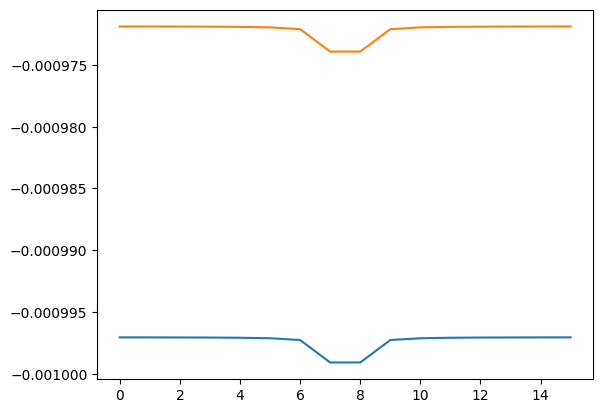

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1461f7717100>

In [15]:
plot(real.(Φ[:, 8, 9]))
plot(real.(Φ_reconst[:, 8, 9]))

maximum(abs, Φ) = 0.0009990781991478792
maximum(abs, Φ_reconst) = 0.0009739218858780351


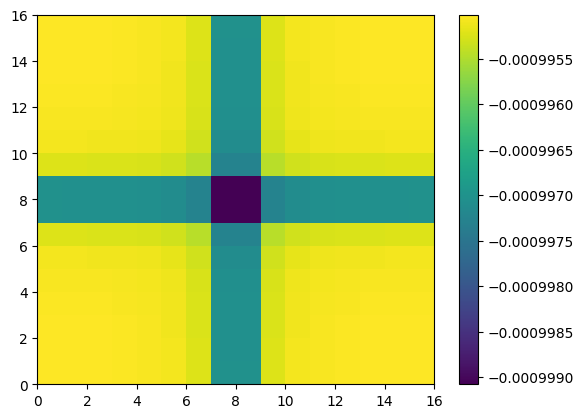

PyObject <matplotlib.colorbar.Colorbar object at 0x1461f3636a30>

In [16]:
@show maximum(abs, Φ)
@show maximum(abs, Φ_reconst)
plt[:pcolormesh](real.(Φ[:, :, 9]))
colorbar()

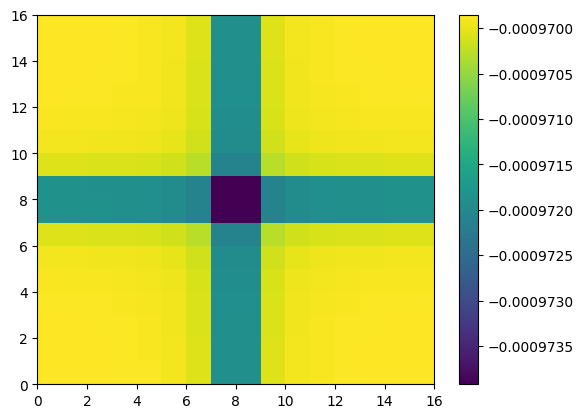

PyObject <matplotlib.colorbar.Colorbar object at 0x1461f3519640>

In [17]:
plt[:pcolormesh](real.(Φ_reconst[:, :, 9]))
colorbar()